<a href="https://colab.research.google.com/github/aka2910/GNR650-Ass1/blob/main/GNR650_Ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task-1
The Final layer is only trained (classifier)



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import vision_transformer
import torchvision
from torch.utils.data import DataLoader, random_split


In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eurosat_dataset=torchvision.datasets.EuroSAT(root="",download=True,transform=transform)



100%|██████████| 94280567/94280567 [00:05<00:00, 17246577.47it/s]


Extracting eurosat/EuroSAT.zip to eurosat


In [3]:
train_ratio = 0.8  # Adjust the ratio as needed
num_samples = len(eurosat_dataset)
train_size = int(train_ratio * num_samples)
test_size = num_samples - train_size
train_dataset, test_dataset = random_split(eurosat_dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
vit_model = vision_transformer.vit_b_16(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 70.7MB/s]


In [12]:
vit_model.heads.head = nn.Linear(in_features=768,out_features=10,bias=True)

for p in vit_model.parameters():
    p.requires_grad = False

for p in vit_model.heads.head.parameters():
    p.requires_grad = True

# for p in vit_model.heads.head.parameters():
#     p.requires_grad = True


In [16]:
num_classes = 10
in_features = 1000

# Combine the ViT model and the new classification layer
model = vit_model

model.to(device)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [18]:
num_epochs = 1  # Adjust the number of epochs as needed
for epoch in range(num_epochs):
    # Training
    model.train()
    for images, labels in train_loader:  # Iterate through your DataLoader
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Training - Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.4f}')

    # Testing
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:  # Iterate through your test DataLoader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and print test accuracy
    test_accuracy = 100 * correct / total
    print(f'Testing - Epoch [{epoch + 1}/{num_epochs}] Accuracy: {test_accuracy:.2f}%')


Training - Epoch [1/1] Loss: 0.2241
Testing - Epoch [1/1] Accuracy: 95.15%


In [48]:
import matplotlib.pyplot as plt


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.encoder.layers.encoder_layer_5.register_forward_hook(get_activation("encoder_layer_5_task1"))


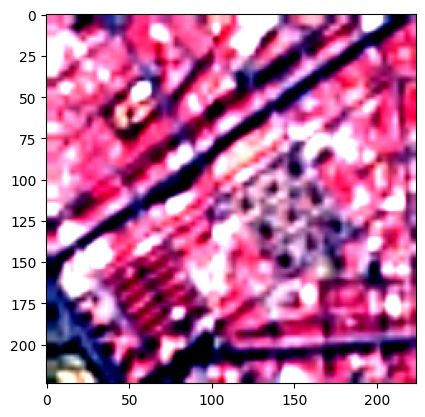

In [49]:
image1 = images[0].detach().numpy()
input_image = images[0]
image1=image1.transpose(1,2,0)
plt.imshow(image1)
plt.show()

In [50]:
output = model(images[0][None,:,:,:].to(device))

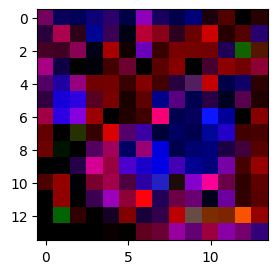

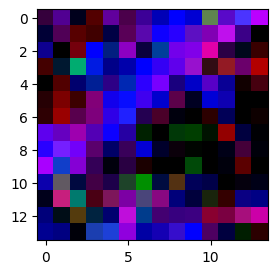

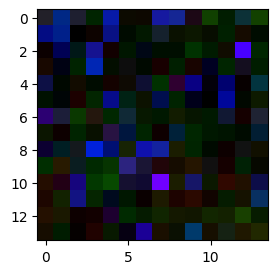

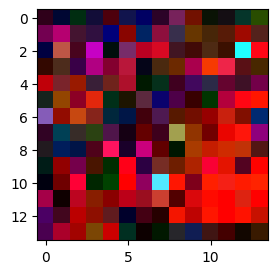

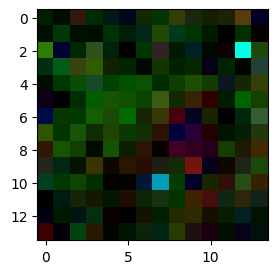

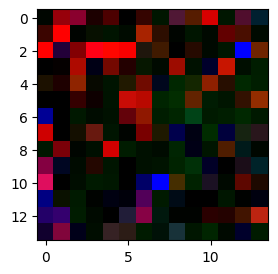

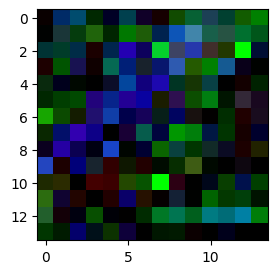

In [67]:
viz=activation["encoder_layer_5_task1"][0,:,:][1:,:]
for i in range(0,21,3):
    img = viz[:, i:i+3].reshape(14,14,3)
    plt.figure(figsize=(3,3))
    plt.imshow(img.cpu().detach().numpy())

## Task-2
finetuning the bottom layers

In [69]:
vit_model = vision_transformer.vit_b_16(pretrained=True)
num_classes = 10
in_features = 1000

# Combine the ViT model and the new classification layer
model = vit_model
vit_model.heads.head = nn.Linear(in_features=768,out_features=10,bias=True)
model.to(device)

for p in vit_model.parameters():
    p.requires_grad = True

for p in vit_model.heads.head.parameters():
    p.requires_grad = False
model = vit_model

In [70]:
num_epochs = 1  # Adjust the number of epochs as needed
for epoch in range(num_epochs):
    # Training
    model.train()
    for images, labels in train_loader:  # Iterate through your DataLoader
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Training - Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.4f}')

    # Testing
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:  # Iterate through your test DataLoader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and print test accuracy
    test_accuracy = 100 * correct / total
    print(f'Testing - Epoch [{epoch + 1}/{num_epochs}] Accuracy: {test_accuracy:.2f}%')


Training - Epoch [1/1] Loss: 0.6955
Testing - Epoch [1/1] Accuracy: 69.46%


In [71]:
import matplotlib.pyplot as plt


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.encoder.layers.encoder_layer_5.register_forward_hook(get_activation("encoder_layer_5_task2"))


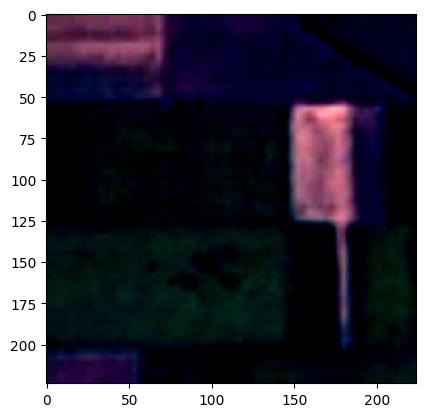

In [73]:
image1 = images.cpu()[0].detach().numpy()
input_image = images[0]
image1=image1.transpose(1,2,0)
plt.imshow(image1)
plt.show()

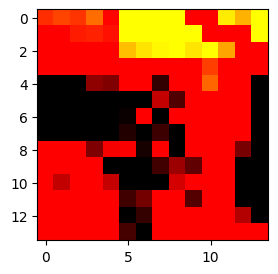

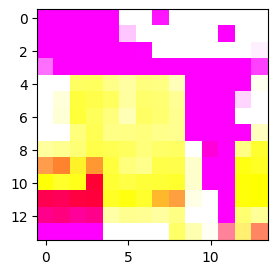

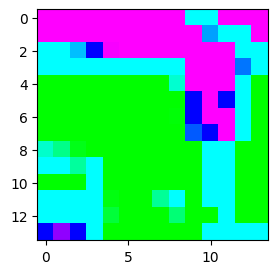

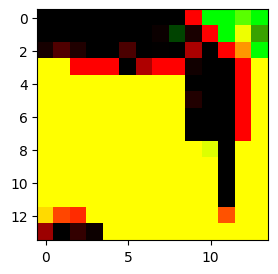

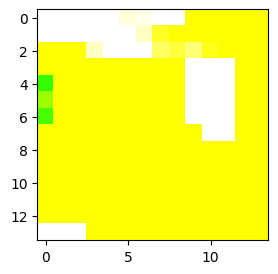

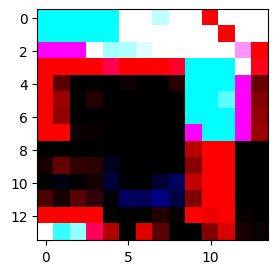

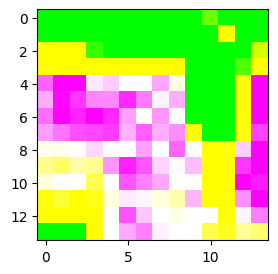

In [74]:
output = model(images[0][None,:,:,:].to(device))
viz=activation["encoder_layer_5_task2"][0,:,:][1:,:]
for i in range(0,21,3):
    img = viz[:, i:i+3].reshape(14,14,3)
    plt.figure(figsize=(3,3))
    plt.imshow(img.cpu().detach().numpy())

## Task-3
full fine tune on the eurosat data

In [82]:
vit_model = vision_transformer.vit_b_16(pretrained=True)
num_classes = 10
in_features = 1000

# Combine the ViT model and the new classification layer
model = vit_model
vit_model.heads.head = nn.Linear(in_features=768,out_features=10,bias=True)

for p in vit_model.parameters():
    p.requires_grad = True


model.to(device)




VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
num_epochs = 1  # Adjust the number of epochs as needed
for epoch in range(num_epochs):
    # Training
    model.train()
    for images, labels in train_loader:  # Iterate through your DataLoader
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Training - Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.4f}')

    # Testing
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:  # Iterate through your test DataLoader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and print test accuracy
    test_accuracy = 100 * correct / total
    print(f'Testing - Epoch [{epoch + 1}/{num_epochs}] Accuracy: {test_accuracy:.2f}%')


In [ ]:
import matplotlib.pyplot as plt


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.encoder.layers.encoder_layer_5.register_forward_hook(get_activation("encoder_layer_5_task3"))


In [ ]:
image1 = images.cpu()[0].detach().numpy()
input_image = images[0]
image1=image1.transpose(1,2,0)
plt.imshow(image1)
plt.show()

In [ ]:
output = model(images[0][None,:,:,:].to(device))
viz=activation["encoder_layer_5_task3"][0,:,:][1:,:]
for i in range(0,21,3):
    img = viz[:, i:i+3].reshape(14,14,3)
    plt.figure(figsize=(3,3))
    plt.imshow(img.cpu().detach().numpy())

## task-4
do not fine tune

In [76]:
vit_model = vision_transformer.vit_b_16(pretrained=True)
num_classes = 10
in_features = 1000

# Combine the ViT model and the new classification layer
model = vit_model
vit_model.heads.head = nn.Linear(in_features=768,out_features=10,bias=True)

for p in vit_model.parameters():
    p.requires_grad = True


model.to(device)




VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [81]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:  # Iterate through your test DataLoader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print test accuracy
test_accuracy = 100 * correct / total
print(f'Testing - Epoch [{epoch + 1}/{num_epochs}] Accuracy: {test_accuracy:.2f}%')

Testing - Epoch [1/1] Accuracy: 9.22%


In [77]:
import matplotlib.pyplot as plt


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.encoder.layers.encoder_layer_5.register_forward_hook(get_activation("encoder_layer_5_task4"))


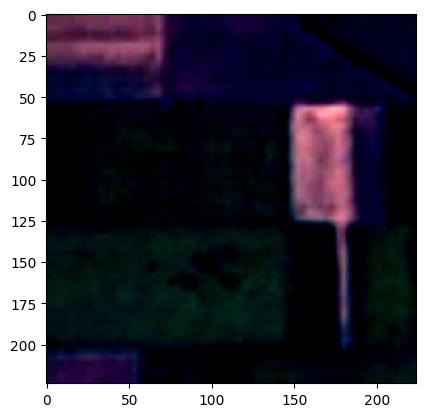

In [78]:
image1 = images.cpu()[0].detach().numpy()
input_image = images[0]
image1=image1.transpose(1,2,0)
plt.imshow(image1)
plt.show()

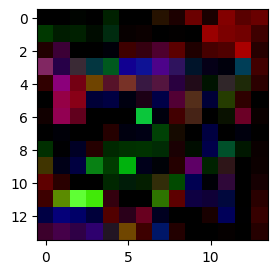

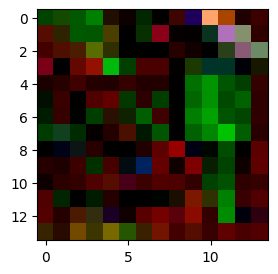

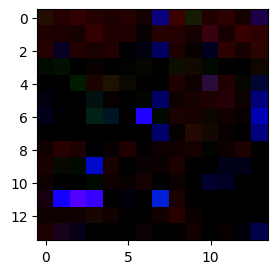

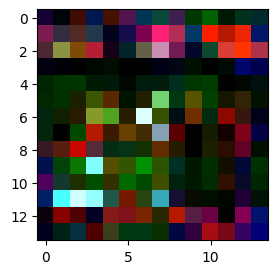

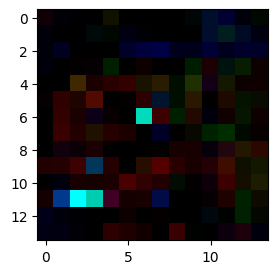

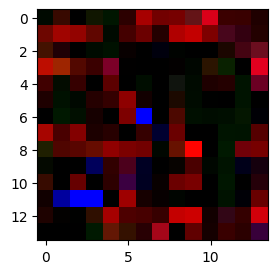

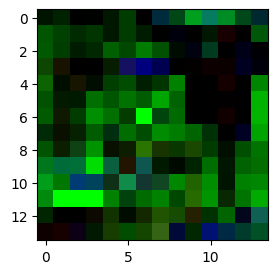

In [80]:
output = model(images[0][None,:,:,:].to(device))
viz=activation["encoder_layer_5_task4"][0,:,:][1:,:]
for i in range(0,21,3):
    img = viz[:, i:i+3].reshape(14,14,3)
    plt.figure(figsize=(3,3))
    plt.imshow(img.cpu().detach().numpy())